# CAB420, Classificaton Summary with Text Data
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example revists our classification methods:
* K-Nearest Neighbours Classification
* Support Vector Machines
* Random Forests
* Deep Neural Networks

In this summary example, we're going to use text data, and in particular we're going to transform this into a Bag of Words representation. This is a new idea for CAB420 - though there is a Bonus example on this back with the classification content that you may have seen. There are a few problems that we may encouter with text data:
* Each piece of text can be a different length, yet our methods all like to see data of the same length;
* While order is important, the *placement* or a word of phrase is somewhat less so. The padding approach that we applied in our earlier multi-class classification example essentially places hard constraints on the placement of words. 

Bag of Words will transform our variable length text into a fixed length representation, and also free us of this placement issue. As always, there's a cost and in this case it's the loss of any order information (though using n-grams we can capture local order, see the bonus example for details) and potentially (depending on our sequence length and other representation choices) a fairly large increase in dimensionality.

Using this Bag of Words (Bow) representation we will then:
* Setup a hold-out validation set for use with a Grid Search
* Train an SVM, CKNN and Random Forest using a Grid Search
* Train a Deep Neural Network, operating over the same BoW data

Hopefully, everything with respect to our model training, parameters, etc will be familar, but if it isn't:
* Ask questions, either in class or online
* Go back and look at the original content in earlier weeks

Note also that in this summary I'm not going to go into any detail on model hyper-parameters. This is covered in a lot of detail in the first Classification summary, and I'd encourage you to review that if you're uncertain.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas
import numpy
import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

import keras
from keras import layers

## The Data
Our data comes from the well of human love and kindness that is twitter. We have 160,000 tweets that have been havested. For each of these, the tweet has been classified as either positive or negative.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv', header = None)
print(tweets.head())

   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In the name of not running this for a week, we're just going to pull out a sample of the data. I'm setting this up to pull our 5,000 training samples, and 1,000 for both validation and testing. Feel free to tweak these numbers yourself if you wish, but if you make them too big the grid searches below will get slow.

Some other things to note here:
* The labels are 0 or 4. For my deep net down below, I want this to be 0 or 1 (the other models don't care). I have a `convert_y` function to deal with this
* I've going to pull out training, validation and testing data; and a combined set of training and validation (where the frist `train_samples` entries are the training data). This combined training and validation set if for use with the grid search.

In [3]:
def convert_y(data):
    return numpy.array([1 if x > 0 else 0 for x in data])

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])

# set the rng for repeatibility
rng = numpy.random.default_rng(4)
# numbers of samples, change at your peril
train_samples = 5000
val_samples = 1000
test_samples = 1000

# select the samples to use
num_samples = train_samples + val_samples + test_samples
samples = rng.choice(len(Y), num_samples)

# training data
train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = convert_y(Y[samples[0:train_samples]])
# pulling out train and val combined to use with the grid search further down
train_and_val_X = [tweet_text[i] for i in samples[0:(train_samples + val_samples)]]
train_and_val_Y = convert_y(Y[samples[0:(train_samples + val_samples)]])
# validation data
val_X = [tweet_text[i] for i in samples[train_samples:(train_samples + val_samples)]]
val_Y = convert_y(Y[samples[train_samples:(train_samples + val_samples)]])
# testing data
test_X = [tweet_text[i] for i in samples[(train_samples + val_samples):]]
test_Y = convert_y(Y[samples[(train_samples + val_samples):]])
# sanity check
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(train_and_val_X))
print(numpy.shape(train_and_val_Y))
print(numpy.shape(val_X))
print(numpy.shape(val_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

(5000,)
(5000,)
(6000,)
(6000,)
(1000,)
(1000,)
(1000,)
(1000,)


Just quickly now, we should have a look at our data.

In [4]:
print(train_X[0:5])

["@mandi_louise cant wait!! It's gonna be EVEN better than last time  i'm all old tho, wait til you get to my age,  LOL!", '@larnsriver hey afternoon ', 'just got back from the movies!!  saw Up!        sooo funny', '@kinggayle I think you are Twittering like a pro ', 'Just showered! No energy whatsoever.. Will be sleeping nude since undies have gone missing, as previously tweeted by @mexicanfrommars  ']


From above, we have tweets and each tweet is a string.

## Bag of Words (BoW)

To get from the above strings to a bag of words, we need to:
* Tokenise our documents. We did this with the earlier beer names example, and it primarily involves converting each string into a set of *tokens*, where each token is a single word. Normally at the same time, we'll convert everything to lower case, remove punctuation, perform lemmatisation, and any other pre-processing we want to do.
* Train our dictionary. BoW is going to convert our string into a histogram. Our histogram has one bin for each word, and then records how often each word occurs in the string. Before we can build the histogram, we need to get our set of histogram bins (i.e. words). 
* Transform our documents from tokens into histograms.

Here, we're going to the the BoW class in sklearn (`CountVectorizer`) do the tokenisation for us, and we'll just use the default setting. There are some other settings that we adjust though, and I'm going to adjust two relating to document frequency:
* Any words that occur in fewer than 0.01% of documents will be excluded, i.e. I'll get rid of very rare words
* Any words that occur in over 25% of documents, I'll also get rid of, as really common words are also likely to be of little use

Both these thresholds are a little arbitrary, and you are welcome to play with them and see what happens.

Once I've setup my `CountVectorizer`, I can then use this to transform documents into a BoW representation.

In [5]:
count_vect = CountVectorizer(min_df=0.0001, max_df=0.25)
X_train_counts = count_vect.fit_transform(train_X)

We can have a look at some of the output. We can see that we now have a sparse matrix for the counts, and we can look at how we go from a tweet to a histogram (or bag or words) to represent that.

In [6]:
print(X_train_counts.shape)
print(train_X[2])
print(X_train_counts[2])

(5000, 11290)
just got back from the movies!!  saw Up!        sooo funny
  (0, 5365)	1
  (0, 4191)	1
  (0, 1046)	1
  (0, 3890)	1
  (0, 6715)	1
  (0, 8610)	1
  (0, 10483)	1
  (0, 9173)	1
  (0, 3935)	1


The representation above may look at a little odd. What you're seeing with the sparse matrix is just the bins that contain something, and the number of samples in those bins. In the above, we have 10 words in our tweet, and 9 entries in our sparse matrix. One word (probably *the*) has been removed for being too common. The rest have been mapped to their histogram bin. As each of these other 9 words occurs once, we have 9 bins with a value of 1.

We can also have a look at the entire vocabulary. Note that everything is lowercase, and the punctuation is stripped out. As noted above, the CountVectorizer does this pre-processing for us. What you can do is quite flexible, and if you're interested you're encouraged to check it out. You could also use a different tokeniser if you wish.

In [7]:
print(count_vect.vocabulary_)

{'mandi_louise': 6175, 'cant': 1783, 'wait': 10682, 'it': 5031, 'gonna': 4163, 'be': 1146, 'even': 3402, 'better': 1257, 'than': 9863, 'last': 5686, 'time': 10043, 'all': 627, 'old': 7223, 'tho': 9973, 'til': 10037, 'you': 11195, 'get': 4046, 'my': 6813, 'age': 516, 'lol': 5946, 'larnsriver': 5680, 'hey': 4554, 'afternoon': 508, 'just': 5365, 'got': 4191, 'back': 1046, 'from': 3890, 'movies': 6715, 'saw': 8610, 'up': 10483, 'sooo': 9173, 'funny': 3935, 'kinggayle': 5525, 'think': 9954, 'are': 830, 'twittering': 10370, 'like': 5833, 'pro': 7874, 'showered': 8892, 'no': 7040, 'energy': 3299, 'whatsoever': 10848, 'will': 10921, 'sleeping': 9026, 'nude': 7117, 'since': 8953, 'undies': 10446, 'have': 4445, 'gone': 4161, 'missing': 6557, 'as': 873, 'previously': 7854, 'tweeted': 10327, 'by': 1697, 'mexicanfrommars': 6445, 'eightymphmom': 3222, 'anytime': 783, 'landed': 5667, 'weeee': 10794, 're': 8110, 'baaaack': 1025, 'dundundunnn': 3120, 'high': 4573, 'five': 3704, 'for': 3801, 'tri': 1024

Finally, we'll transform the rest of our data into the same representation.

In [8]:
X_train_and_val_counts = count_vect.transform(train_and_val_X)
print(X_train_and_val_counts.shape)
X_val_counts = count_vect.transform(val_X)
print(X_val_counts.shape)
X_test_counts = count_vect.transform(test_X)
print(X_test_counts.shape)

(6000, 11290)
(1000, 11290)
(1000, 11290)


One thing to note here is the size of this output. Each of our features is over $10,000$ elements in length. These are big.

## Grid Search Setup

We're going to use a grid search here, and I want to set this up to use a hold-out validation set, i.e. I'll have a chunk of training data, and a chunck of validation data, and they are going to be totally separate. This is just what we've done most other times, but here I'm going to do via the grid search object.

What I need to do is create a `PredefinedSplit`, and I'll pass into that a vector that indicates which samples belong to training and validation. Then, I'll pass in my data array when I setup the grid search, and my data will be split into training and validation as I specify here. This is why we created a combined training and validation set up top.

In [9]:
# data flag vector is the same length as the combined training and validation set
split = numpy.zeros((train_samples + val_samples, 1))
# set the first train_samples to be in the training set
split[0:train_samples] = -1
# the last val_samples entries in the split will have a value of 0, which will place these in the first 
# (and only) testing split 
# pass the split definition to a PredefinedSplit object
ps = PredefinedSplit(split)

## Support Vector Machines

Let's start with a Support Vector Machine. In my grid search, I'll consider:
* C
* Kernel type
* Kernel parameters

Note that as each kernel has different parameters, this means that I've effectivley got three grids.

In [10]:
# setup parameter grid. Effectivley one grid for each kernel
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5, 6], 'kernel': ['poly']},
 ]
# create the SVM
svm = SVC()
# and now run the grid search. Note that:
# - the pre-defined split object is being passed into the GridSearch to define the splits
# - fit is then using the combined train and validation data
svm_grid = GridSearchCV(svm, param_grid, cv = ps).fit(X_train_and_val_counts, train_and_val_Y)

In [11]:
best_model = numpy.argmax(svm_grid.cv_results_['mean_test_score'])
print('\nBest Model:')
print(svm_grid.cv_results_['params'][best_model])


Best Model:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Now, fit the best model and evaluate that on the test set. Note that here The code's a bit ugly as we have three possible kernels, each with different parameters, etc.

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       522
           1       0.71      0.71      0.71       478

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



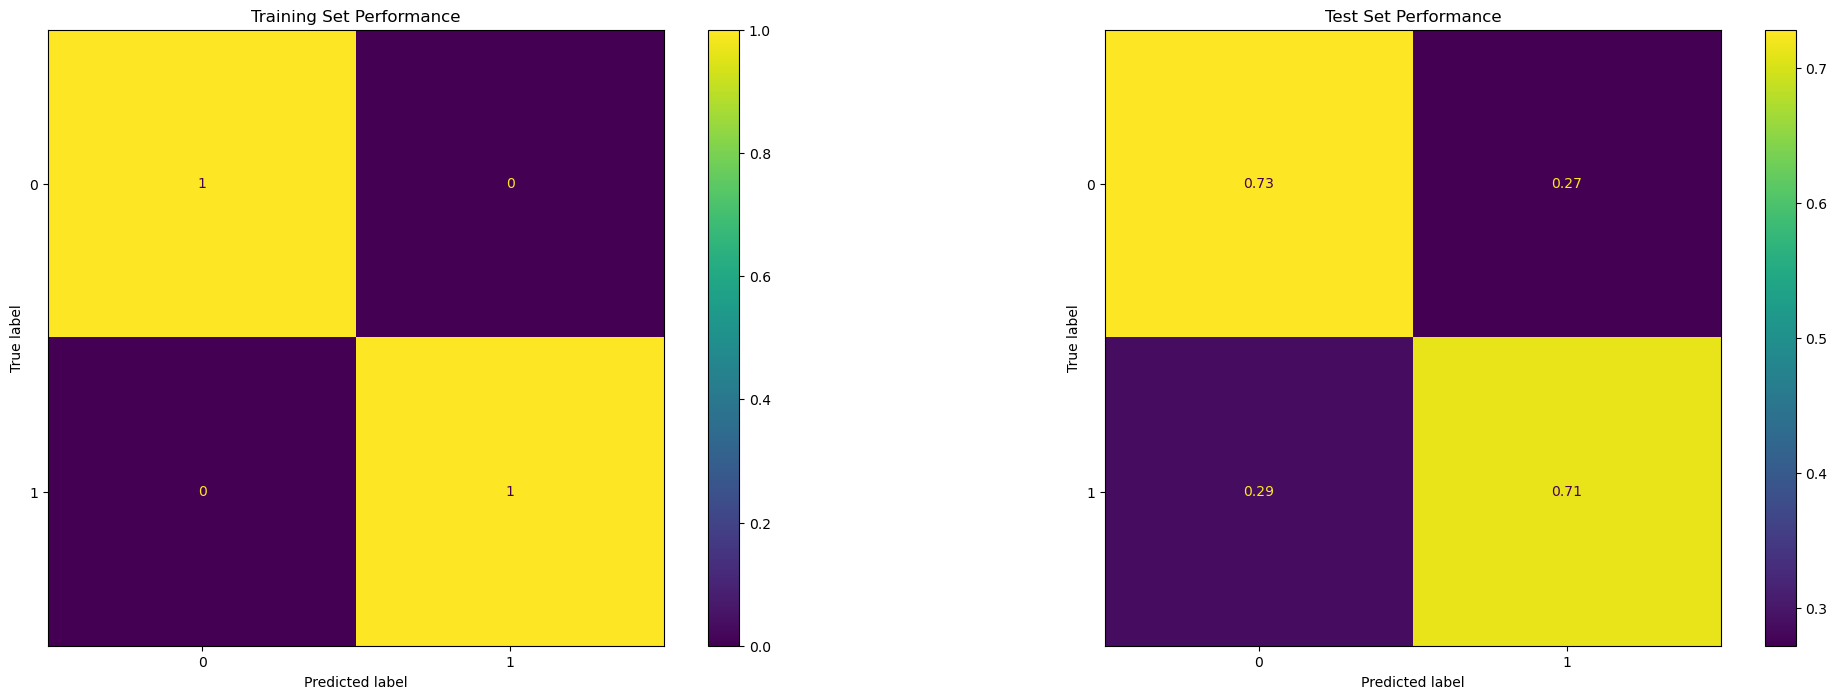

In [12]:
# eval function - you've seen this before
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print(classification_report(Y_test, model.predict(X_test))) 
    
# create the best SVM. The parameters for this depend on the selected kernel, hence the stuffing around
if (svm_grid.cv_results_['params'][best_model]['kernel'] == 'rbf'):
    svm = SVC(C = svm_grid.cv_results_['params'][best_model]['C'], \
              kernel = svm_grid.cv_results_['params'][best_model]['kernel'], \
              gamma = svm_grid.cv_results_['params'][best_model]['gamma'])
elif (svm_grid.cv_results_['params'][best_model]['kernel'] == 'poly'):
    svm = SVC(C = svm_grid.cv_results_['params'][best_model]['C'], \
              kernel = svm_grid.cv_results_['params'][best_model]['kernel'], \
              degree = svm_grid.cv_results_['params'][best_model]['degree'])   
else:
    svm = SVC(C = svm_grid.cv_results_['params'][best_model]['C'], \
              kernel = svm_grid.cv_results_['params'][best_model]['kernel'])   

# fit and evaluate the best SVM
svm.fit(X_train_counts, train_Y)
eval_model(svm, X_train_counts, train_Y, X_test_counts, test_Y)

Our SVM works pretty well, and is very consistent across both classes. It does seem to be overfitting, but this is the model that gave us the best results on the validation set, so we'll take it. That said, this may be a suggestion to go and try some other values in the grid search.

The grid used here is quite coarse, and we could easily search again around the best selected location.

### A Note on SVMs and BoW Representations

SVMs have been very widely used in BoW representations. Quite often, a linear SVM is chosen. While the linear SVM has not worked best here, it is still a good choice. Linear SVMs generally work well with high dimensional sparse data, like we have with a Bag of Words representation.

These also make sense intuitively too. An SVM is finding a hyper-plane to separate our classes. If the classes we're using word histograms to describe our classes, then we can think of this hyper-plane as finding key words that occur in one class and not the other, and separating the classes based on these.

## CKNN

K-nearest neighbours classification now. We'll consider:
* the number of neighbours;
* our weighting scheme; and
* our distance metric, though we'll stick to just cityblock or euclidean.

The rest of the grid search setup is the same as last time.

In [13]:
param_grid = {'n_neighbors' : [1, 2, 4, 8, 16, 32, 64, 128, 256], 'weights' : ['uniform', 'distance'], \
              'metric' : ['cityblock', 'euclidean']}
cknn = KNeighborsClassifier()
cknn_grid = GridSearchCV(cknn, param_grid, cv = ps).fit(X_train_and_val_counts, train_and_val_Y)

In [14]:
best_model = numpy.argmax(cknn_grid.cv_results_['mean_test_score'])
print('\nBest Model:')
print(cknn_grid.cv_results_['params'][best_model])


Best Model:
{'metric': 'euclidean', 'n_neighbors': 64, 'weights': 'distance'}


              precision    recall  f1-score   support

           0       0.60      0.82      0.69       522
           1       0.67      0.41      0.51       478

    accuracy                           0.62      1000
   macro avg       0.64      0.61      0.60      1000
weighted avg       0.64      0.62      0.60      1000



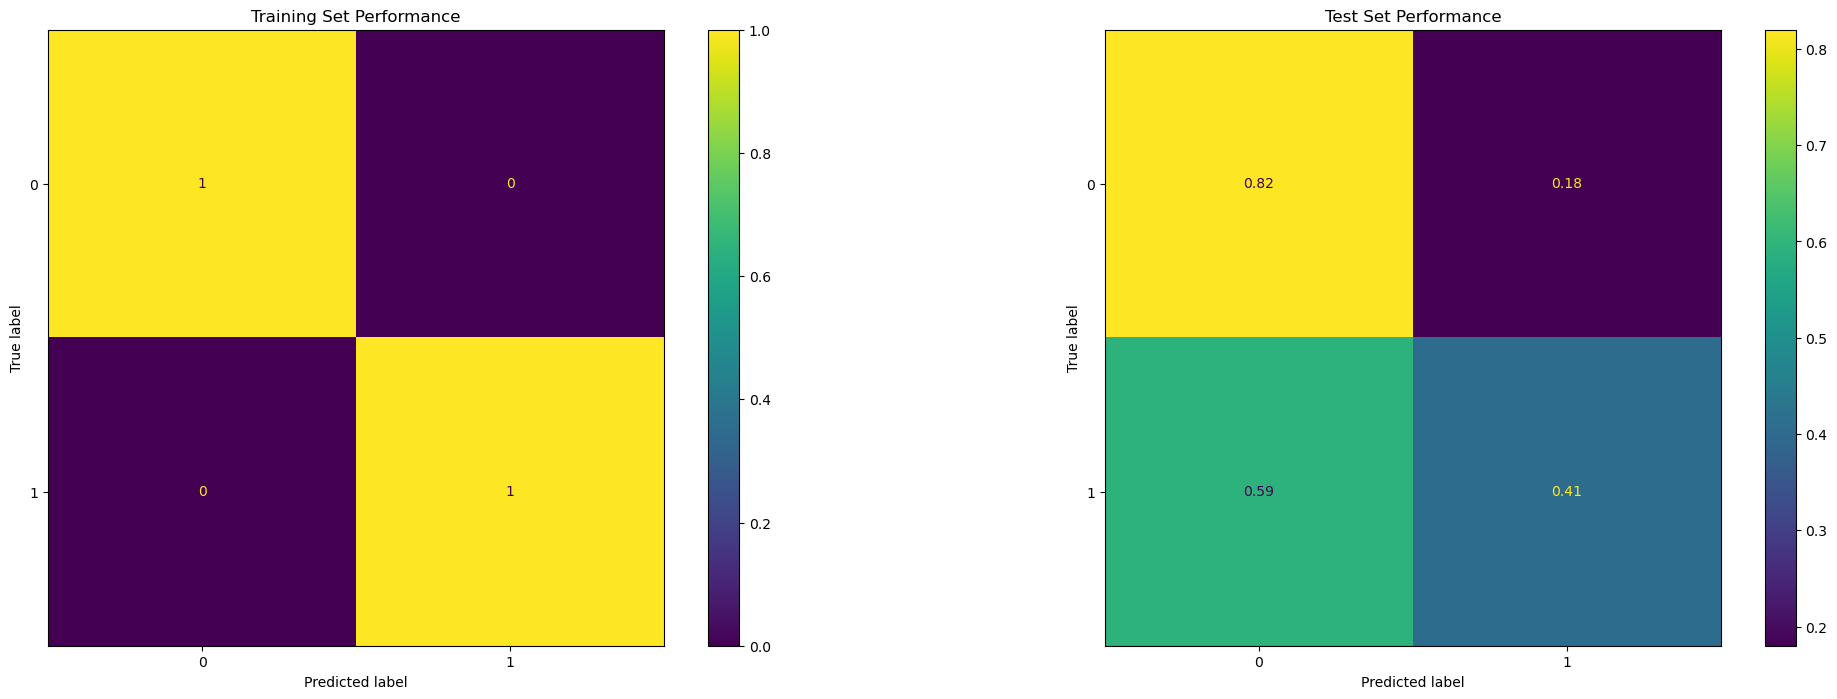

In [15]:
cknn = KNeighborsClassifier(n_neighbors = cknn_grid.cv_results_['params'][best_model]['n_neighbors'], \
                            weights = cknn_grid.cv_results_['params'][best_model]['weights'],\
                            metric = cknn_grid.cv_results_['params'][best_model]['metric'])
cknn.fit(X_train_counts, train_Y)
eval_model(cknn, X_train_counts, train_Y, X_test_counts, test_Y)

Performance is substantially down from what we saw on our SVM. Before we dig into why, let's first address the overfitting. In this case, this is not a concern, and in fact it's completely expected given the configuration that we've ended up with. Using a weighting scheme based on the inverse distance will lead to this exact behaviour, and we can't avoid it. 

### A Brief Aside - Why the above is not really overfitting

To explain why, consider what a distance based weighting scheme is doing. When we pull out our 64 nearest neighbours, with a uniform weighting scheme each of these 64 neighbours gets one vote, and we take whatever is most popular across the 64 neighbours. With the distance based scheme, what we do instead is we give each of those 64 neighbours a weight. The weight is $\frac{1}{d}$, where $d$ is the distance between the neighbour, and the point we're trying to classify. Essentially, neighbours that are closer will get higher weights. If we evaluate on the training set through, things get a bit weird. We pull out our set of neighbours, but now within that set of neighbours is the exact same point (we're evaluating on the training set, so the same set of points are used for training and evaluation). With a distance based wieghting scheme, when the point we're evaluating and it's neighbour are the same, $d = 0$, and thus our weight becomes $\frac{1}{0} = \infty$. As such, this neighbour and this neighbour alone decides the classification result, and as this neighbour is the same point, the class that is select is correct; hence we get perfect results. The model is not overfitting in this case as the design of the model in this case doesn't allow anything other than perfect results (the only exception to this would be if we had multiple identical points in the dataset, though these identical points were assigned to different classes).

### CKNN vs SVM

So why does the CKNN suck so much? Really it comes down to the nature of the representation. The CKNN will look at the difference across all dimensions in the data. Some of those dimensions may be totally uninformative, yet differences will still get noted and counted by the model and influence the final decision. The SVM on the other hand can be a bit more selective. It can't ignore a dimension, but it can place the hyper-plane such that changes in that dimension are effectivley not considered (though, extreme data values may then result in some unexpected results). As always this doesn't mean that the SVM is always the winning choice, but generally with BoW data SVMs are a good option.

# Random Forests

Now to random forests. Here, we'll consider:
* Tree depth
* The number of estimators

Again, it's grid search time, using some code that looks like it might have been copy/pasted from above.

In [16]:
param_grid = {'max_depth': [2, 4, 8, 16, 32, 64, 128, None], 'n_estimators' : [25, 50, 100, 200, 400, 800, 1600]}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid, cv = ps).fit(X_train_and_val_counts, train_and_val_Y)

In [17]:
best_model = numpy.argmax(rf_grid.cv_results_['mean_test_score'])
print('\nBest Model:')
print(rf_grid.cv_results_['params'][best_model])


Best Model:
{'max_depth': None, 'n_estimators': 400}


              precision    recall  f1-score   support

           0       0.74      0.72      0.73       522
           1       0.70      0.73      0.71       478

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



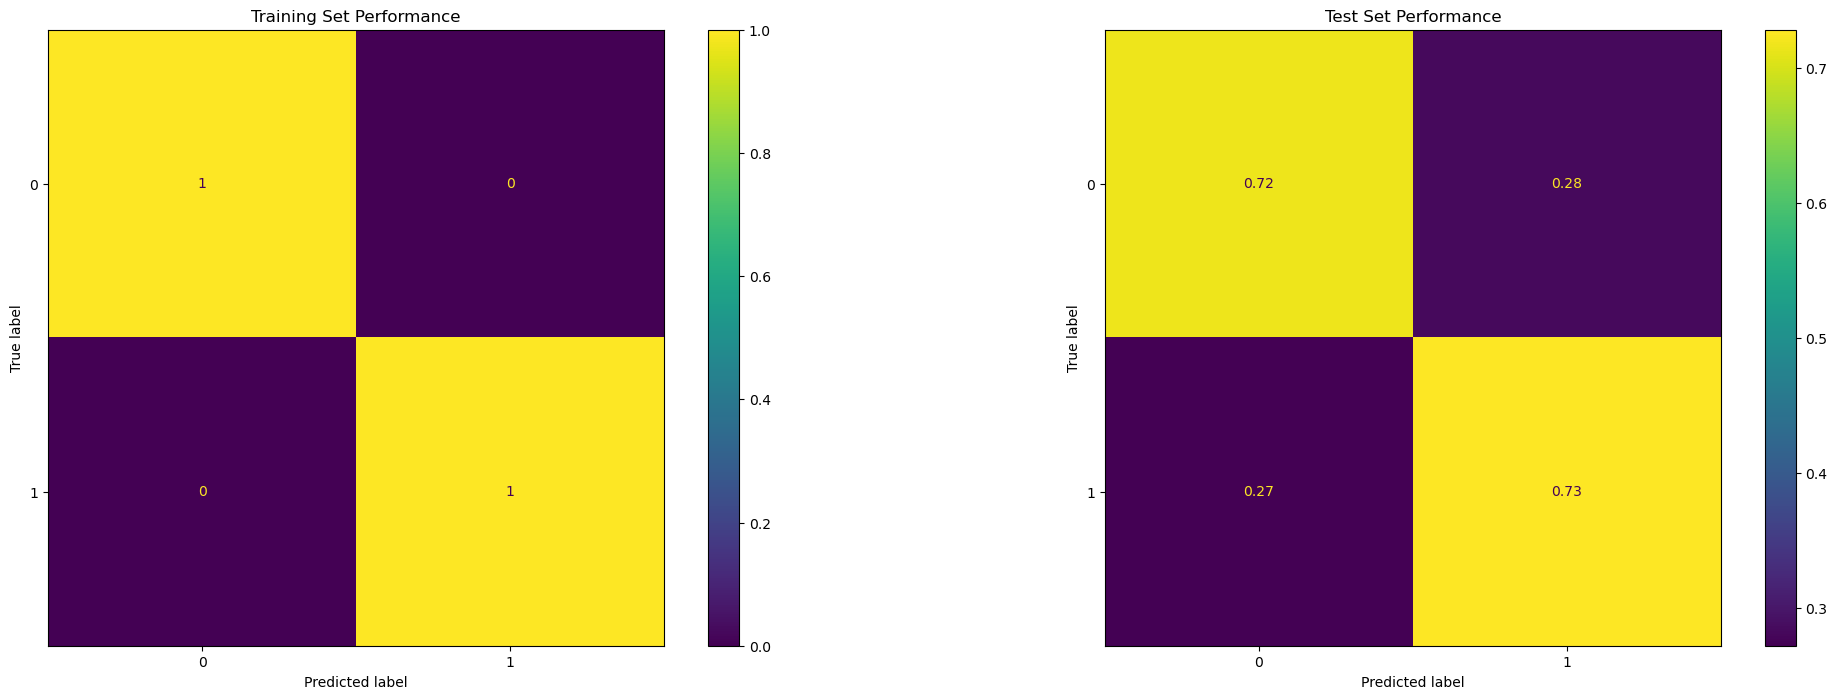

In [18]:
rf = RandomForestClassifier(max_depth = rf_grid.cv_results_['params'][best_model]['max_depth'], \
                            n_estimators = rf_grid.cv_results_['params'][best_model]['n_estimators'])
rf.fit(X_train_counts, train_Y)
eval_model(rf, X_train_counts, train_Y, X_test_counts, test_Y)

We're back to better performance again here. In our random forests, each tree is able to select appropriate features to divide the data into positive and negative tweets. As such, our model can identify the words that are best to separate these, and ignore those with little to no value. With as many dimensions as we have, a lot of them are going to be useless, so having a classifier that is able to be somewhat selective is a nice trick.

## Deep Nets?

Finally, let's look at deep nets for this. I'm going to use a fully connected network here. Our input is huge. We'll then quickly scale our representation down towards a single output, as we have a binary classification task.

In [19]:
inputs = keras.Input(shape=(11290, ), name='inp')
x = layers.Dense(1024, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# build the model and print a summary
model_dnn = keras.Model(inputs=inputs, outputs=outputs, name='bow_dnn')
model_dnn.summary()

# train the model
model_dnn.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=False)

Model: "bow_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ inp (InputLayer)                │ (None, 11290)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │ 11,561,984 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 128)               │    131,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 11,693,313 (44.61 MB)

 Trainable params: 11,693,313 (44.61 MB)

 Non-trainable params: 0 (0.00 B)

This results in a huge number of parameters, largely due to the huge size of our input and the use of dense layers throughout.

This this also poses an interesting question with respect to how long we train the model for. We have only 5,000 training samples. Normally, we'd want to run a lot of epochs to get lots of iterations here so that we give our model time to train. That's not going to end well here.

Here, we'll use a batch size of 32, giving us 157 batches per epoch. We'll train for 10 epochs, giving us all up 1570 gradient descent iterations. This is well below what we'd normally use - but it will be more than enough here.

In [20]:
history = model_dnn.fit(X_train_counts.todense(), train_Y,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val_counts.todense(), val_Y))

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6375 - loss: 0.6360 - val_accuracy: 0.7139 - val_loss: 0.5550
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9249 - loss: 0.2207 - val_accuracy: 0.6992 - val_loss: 0.7236
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9882 - loss: 0.0392 - val_accuracy: 0.7070 - val_loss: 1.0026
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9979 - loss: 0.0049 - val_accuracy: 0.7051 - val_loss: 1.1675
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.7090 - val_loss: 1.3098
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.6985e-04 - val_accuracy: 0.7080 - val_loss: 1.3858
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2527e-04 - val_accuracy: 0.7100 - val_loss: 1.4481
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6461e-04 - val

From the output, we see some vairly massive overfitting going on. Training loss is very tiny, and training accuracy is perfect. Meanwhile, validation loss is rapidly going in the wrong direction (and has been since sometime during the first epoch) and validation accuracy, while mostly stable, is slowing going backwards.

We have an insane number of parameters, and a tiny dataset. Further, there is no appropriate augmentation we could use here, and no suitable network to adapt from. This is one situation where a deep network is not the best option.

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       522
           1       0.71      0.65      0.68       478

    accuracy                           0.71      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.71      0.71      1000



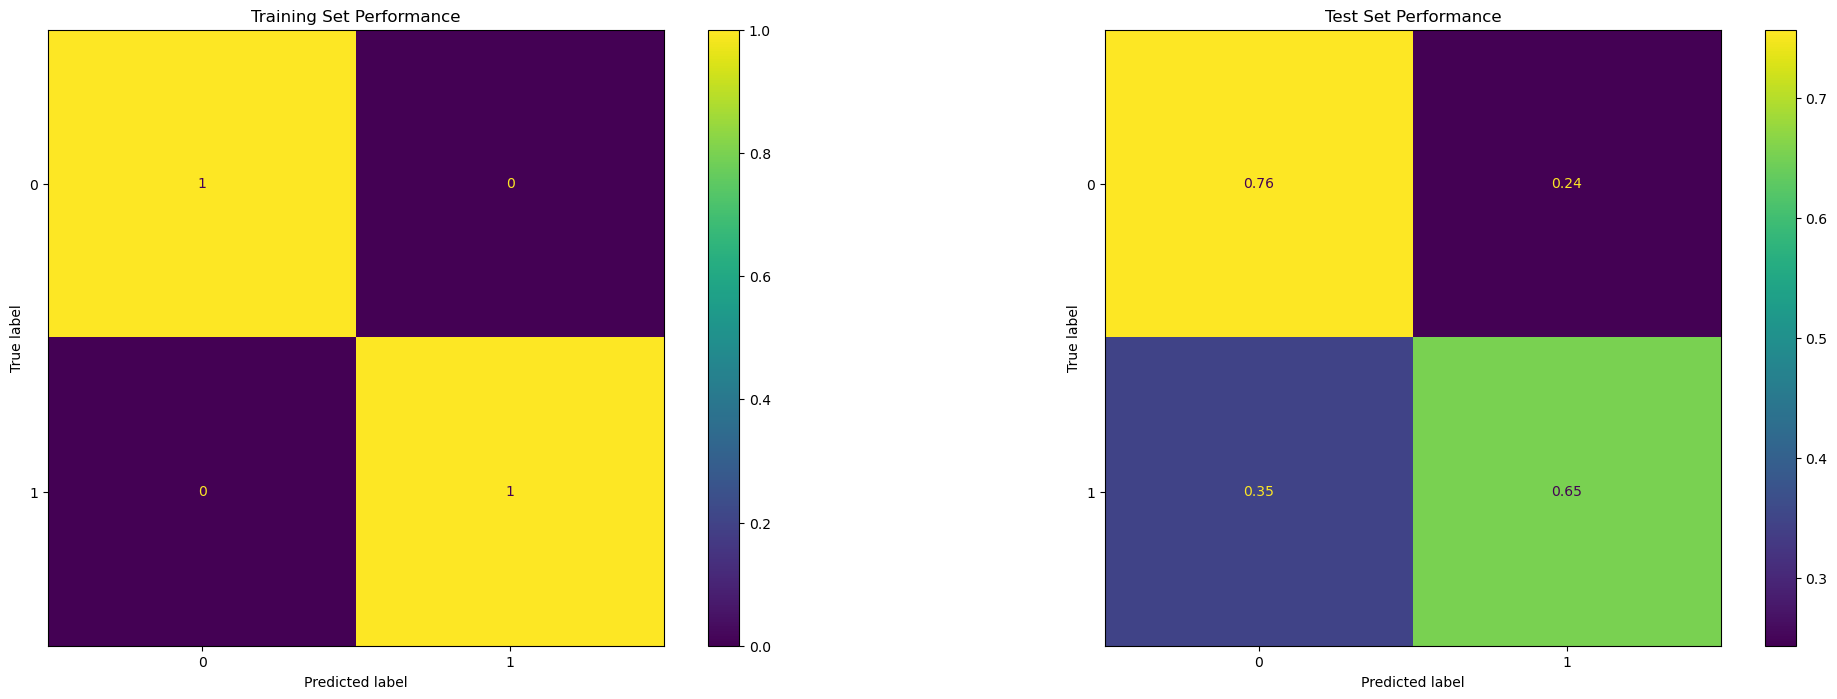

In [21]:
def eval_dnn(model, X_train, Y_train, X_test, Y_test, threshold = 0.5):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(X_train, verbose=False) > 0.5    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = train_Y, y_pred = pred, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance')

    ax = fig.add_subplot(1, 2, 2)
    pred = model.predict(X_test, verbose=False) > 0.5    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = pred, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance')
    print(classification_report(Y_test, pred))

eval_dnn(model_dnn, X_train_counts.todense(), train_Y, X_test_counts.todense(), test_Y)

Our network is ok results wise, but it's no better than the SVM or random forest.

### But what about convolutions?

What about them? They don't make sense here. We have (very sparse) histograms of word counts. Each dimensions of our data (or column) is a different word. A convolution filter applies an operation across neighbouring dimensions (column) based on relationships between neighbouring dimensions. In an image context, this might be mean edges or corners. In an audio context, it might mean fluctuations in amplitude at certain frequencies. But what does it mean in the context of a histogram of words? Ultimtley, convolution filters are meaningless in this context.

I will note, this doesn't mean you can't use them - people have and will continue to use DCNNs for all sort of things where the representation being learnt by the model makes no sense; and if you want to you can do so here. I, however, will not. As noted above, a convolutional representation does not make sense.

### But isn't deep learning state of the art for natural language processing (NLP)?

Yep, but state of the art systems use transformers, which are very different to a DCNN. We'll look at these briefly later in semseter.